# 11

## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **NB:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)



# 1 
загружаем

In [182]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,8)}, style="whitegrid")

In [183]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-inchenko-23/churn.csv')

In [184]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [185]:
df.shape

(50000, 12)

In [186]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [187]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
luxury_car_user              bool
weekday_pct               float64
dtype: object

In [188]:
#Изменяем тип для дат
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [189]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


# 2
#### Графики, Гипотезы и Тесты

Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней

In [190]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [191]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

#Преобразуем в int
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [266]:
#Если с момента последней поездки прошло более 30 дней - пользователь считается покинувшим приложение [предположение]
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn
...,...,...
49995,26,not_churn
49996,157,churn
49997,40,churn
49998,167,churn


### churn

Видим, что очень много пользователей не использовали сервис в последнем месяце. Какие факторы могут влиять на отток водителей?

In [193]:
df.churn.value_counts(normalize=True).mul(100)

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

Оотразим на графике нормализованные значения (сравниваем не сырые числа):

In [273]:
fig = px.histogram(df, x='churn', histnorm='probability density')
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [195]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


In [196]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', 
                   color='phone')
fig.show()

Не будем делать вывод только по графику, а проверим гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [197]:
from scipy.stats import chi2_contingency, chi2 

In [274]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))
stat, p

(2558.394212267425, 0.0)

Интерпретируем результат:

In [200]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


# 1
**Проверьте, есть ли различия оттока клиентов в разных городах**

Для проверки этой гипотезы я использую **Хи-квадрат**, поскольку обе переменные - категориальные:
- churn (churn, not_churn), 
- city (Winterfell, Astapor, King's Landing)

In [205]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [276]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))
stat, p

(3821.5510225559633, 0.0)

#### Отклоняем Ho, так как p_value < 0.05 => взаимосвязь есть

# 2
#### Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? 

In [203]:
import scipy.stats
from scipy.stats import shapiro

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



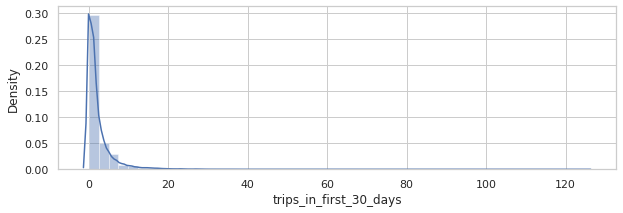

In [275]:
#Посмотрим на распределение
sns.distplot(df.trips_in_first_30_days)
plt.rcParams["figure.figsize"] = (8,3)

In [226]:
#Создадим отдельные датафреймы для каждого из 3 городов, отберем зависимую переменную - количество заказов за первые 30 дней
city_winterfell= df[df['city'] == 'Winterfell'].trips_in_first_30_days
city_astapor = df[df['city'] == 'Astapor'].trips_in_first_30_days
city_king= df[df['city'] == "King's Landing"].trips_in_first_30_days

Проведем тест Шапиро -Уилка. Установим sample=1000, чтобы тест не находил самые незначительные отклонения от нормальности из-за слишком большой выборки, поэтому отбираем 1000 случайных значений. Также установим аргумент random_state = 17 для стабильности результатов.

In [207]:
scipy.stats.shapiro(city_winterfell.sample(1000, random_state=17))

ShapiroResult(statistic=0.5455795526504517, pvalue=7.006492321624085e-45)

In [208]:
scipy.stats.shapiro(city_astapor.sample(1000, random_state=17))

ShapiroResult(statistic=0.5414707660675049, pvalue=4.203895392974451e-45)

In [209]:
scipy.stats.shapiro(city_king.sample(1000, random_state=17))

ShapiroResult(statistic=0.6132159233093262, pvalue=1.6829594556541053e-42)

p_value везде принимает очень маленькие значения, 

**Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA - критерий Краскелла-Уоллиса**

# 3
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days) Обнаружены ли статистически значимые различия?

In [239]:
from scipy import stats
from scipy.stats.mstats import kruskal
kruskal(city_king.values,city_winterfell.values,city_astapor.values)

KruskalResult(statistic=221.32105325320535, pvalue=8.724567791804361e-49)

In [277]:
#Либо второй способ, через библиотеку pingouin
from pingouin import kruskal, read_dataset

In [217]:
kruskal(data=df, dv='trips_in_first_30_days', between='city')

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


**Обнаружены статистически значимые различия, посмотрим, где именно**

In [219]:
import scikit_posthocs as sp

In [225]:
sp.posthoc_dunn(df, val_col='trips_in_first_30_days', group_col='city', p_adjust='holm')

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


#### все значение p также сильно меньше 0.05, значит, все 3 города сильно различаются между собой


# 4
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

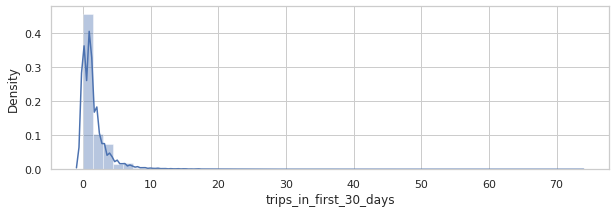

In [243]:
#Распределение переменной trips_in_first_30_days в группе "оттока"
sns.distplot(df[df['churn'] == 'churn']['trips_in_first_30_days'])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



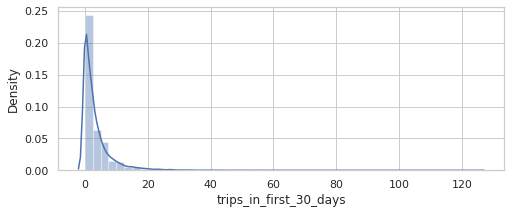

In [279]:
#Распределение переменной trips_in_first_30_days в группе, которая НЕ составляет "отток"
sns.distplot(df[df['churn'] == 'not_churn']['trips_in_first_30_days'])

Распределение переменной trips_in_first_30_days **ненормальное**, поэтому для проверки гипотезы я использую U-критерий Манна-Уитни

In [253]:
stats.mannwhitneyu(df[df['churn'] == 'churn']['trips_in_first_30_days'] ,df[df['churn'] == 'not_churn']['trips_in_first_30_days'])

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

Результат оказался значимым

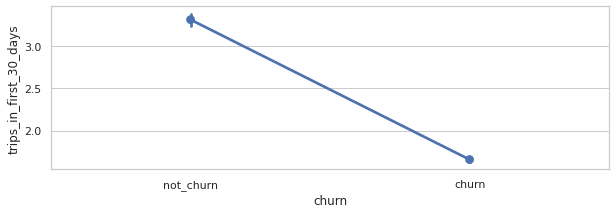

In [265]:
sns.pointplot(x= df.churn, y = df.trips_in_first_30_days)

### В результате видим, что значимые различия есть. Среди тех, кто менее активно пользовался приложением, большой отток
Среди идей - "цеплять" пользователей с самого начала, например, программой лояльности/бонусами, а затем провести A/B -тестирование, чтобы узнать. поможет ли карта лояльности удержать пользователей.